In [72]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [2]:
"""
layers.py
"""
def fc_forward(x, w, b):
    """
    Computes the forward pass for a fully-connected layer.
    
    The input x has shape (N, Din) and contains a minibatch of N
    examples, where each example x[i] has shape (Din,).
    
    Inputs:
    - x: A numpy array containing input data, of shape (N, Din)
    - w: A numpy array of weights, of shape (Din, Dout)
    - b: A numpy array of biases, of shape (Dout,)
    
    Returns a tuple of:
    - out: output, of shape (N, Dout)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the forward pass. Store the result in out.              #
    ###########################################################################
    N, D_in = x.shape
    _, D_out = w.shape
    out = np.dot(x, w) + b  # (N, D_in) @ (D_in, D_out) -> (N, D_out)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache


def fc_backward(dout, cache):
    """
    Computes the backward pass for a fully_connected layer.
    
    Inputs:
    - dout: Upstream derivative, of shape (N, Dout)
    - cache: returned by your forward function. Tuple of:
      - x: Input data, of shape (N, Din)
      - w: Weights, of shape (Din, Dout)
      - b: Biases, of shape (Dout,)
      
    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, Din)
    - dw: Gradient with respect to w, of shape (Din, Dout)
    - db: Gradient with respect to b, of shape (Dout,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    N, D_out = dout.shape
    dx = np.dot(dout, w.T)  # (N, D_out) @ (D_out, D_in) -> (N, D_in)
    dw = np.dot(x.T, dout)  # (D_in, N) @ (N, D_out) -> (D_in, D_out)
    db = np.dot(dout.T, np.ones(N))  # (D_out, N) @ (N, 1) -> (D_out, 1)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

def l2_loss(x, y):
    """
    Computes the loss and gradient of L2 loss.
    loss = 1/N * sum((x - y)**2)

    Inputs:
    - x: Input data, of shape (N, D)
    - y: Output data, of shape (N, D)

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None
    ###########################################################################
    # TODO: Implement L2 loss                                                 #
    ###########################################################################
    N, D = x.shape
    loss = (1 / N) * np.sum(np.power(x - y, 2))
    dx = (2 / N) * (x - y)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return loss, dx

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    out = np.maximum(0, x)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: returned by your forward function. Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    dx = np.array(dout, copy=True)
    dx[x <= 0] = 0
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

def softmax_loss(x, y):
    """
     Computes the loss and gradient for softmax classification.

     Inputs:
     - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
       class for the ith input.
     - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
       0 <= y[i] < C

     Returns a tuple of:
     - loss: Scalar giving the loss
     - dx: Gradient of the loss with respect to x
     """
    loss, dx = None, None
    N, C = x.shape
    ###########################################################################
    # TODO: Implement softmax loss                                            #
    ###########################################################################
    # loss
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    y_hat = e_x / np.sum(e_x, axis=1, keepdims=True)
    loss = -np.sum(np.log(y_hat[np.arange(N), y])) / N
    
    # gradient
    dx = y_hat.copy()
    dx[np.arange(N), y] -= 1
    dx = dx / N
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return loss, dx

In [4]:
"""
fitting.py
"""
def lsq(X, Y, learning_rate=5e-3):
    """
    Inputs:
    - X: Array, of shape (N,2)
    - Y: Array, of shape (N,2)
    - learning_rate: A scalar for initial learning rate
    """
    S = np.ones((2, 2))
    t = np.zeros(2)
    for i in range(10000):
        fwd, cache = fc_forward(X, S, t)
        loss, dloss = l2_loss(fwd, Y)
        dx, dS, dt = fc_backward(dloss, cache)
        # You now have the derivative of w in dw and the derivative 
        # of b in dd, update w, b with gradient descent
        S -= learning_rate * dS
        t -= learning_rate * dt
        
    return S, t

In [60]:
"""
train.py
"""
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding="latin1")
    return dict

def preprocess_images(M):
    # convert to grayscale
    M = M / 255.0
    # normalize
    M = (M - M.mean()) / M.std()
    # return
    return M

def load_cifar10():
    data = {}
    base_path = "C:/Users/Admin/Desktop/"
    meta = unpickle(base_path + "cifar-10-batches-py/batches.meta")
    batch1 = unpickle(base_path + "cifar-10-batches-py/data_batch_1")
    batch2 = unpickle(base_path + "cifar-10-batches-py/data_batch_2")
    batch3 = unpickle(base_path + "cifar-10-batches-py/data_batch_3")
    batch4 = unpickle(base_path + "cifar-10-batches-py/data_batch_4")
    batch5 = unpickle(base_path + "cifar-10-batches-py/data_batch_5")
    test_batch = unpickle(base_path + "cifar-10-batches-py/test_batch")
    
    X_train = np.vstack((
        batch1['data'], batch2['data'],
        batch3['data'], batch4['data'], batch5['data']
    ))
    Y_train = np.array(batch1['labels'] + batch2['labels'] + batch3['labels'] + 
                       batch4['labels'] + batch5['labels'])
    X_test = test_batch['data']
    Y_test = test_batch['labels']
    #######################################################################
    # TODO: Preprocess images here                                        #
    #######################################################################
    X_train = preprocess_images(X_train)
    X_test = preprocess_images(X_test)
    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    #######################################################################
    # Optional: you're free to adjust the training and val split.         #
    #######################################################################
    data['X_train'] = X_train[:40000]
    data['y_train'] = Y_train
    data['X_val'] = X_train[40000:]
    data['y_val'] = Y_train[40000:]
    data['X_test'] = X_test
    data['y_test'] = Y_test
    return data

def testNetwork(model, X, y, num_samples=None, batch_size=100):
    """
    Check accuracy of the model on the provided data.
    Inputs:
    - model: Image classifier
    - X: Array of data, of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,)
    - num_samples: If not None, subsample the data and only test the model
      on num_samples datapoints.
    - batch_size: Split X and y into batches of this size to avoid using
      too much memory.
    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
      classified by the model.
    """
    # Subsample the data
    N = X.shape[0]
    if num_samples is not None and N > num_samples:
        mask = np.random.choice(N, num_samples)
        N = num_samples
        X = X[mask]
        y = y[mask]

    # Compute predictions in batches
    num_batches = N // batch_size
    if N % batch_size != 0:
        num_batches += 1
    y_pred = []
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        scores = model.forwards_backwards(X[start:end])
        y_pred.append(np.argmax(scores, axis=1))
    y_pred = np.hstack(y_pred)
    acc = np.mean(y_pred == y)

    return acc

def trainNetwork(model, data, **kwargs):
    """
     Required arguments:
    - model: Image classifier
    - data: A dictionary of training and validation data containing:
      'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
      'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
      'y_train': Array, shape (N_train,) of labels for training images
      'y_val': Array, shape (N_val,) of labels for validation images

    Optional arguments:
    - learning_rate: A scalar for initial learning rate.
    - lr_decay: A scalar for learning rate decay; after each epoch the
      learning rate is multiplied by this value.
    - batch_size: Size of minibatches used to compute loss and gradient
      during training.
    - num_epochs: The number of epochs to run for during training.
    - print_every: Integer; training losses will be printed every
      print_every iterations.
    - verbose: Boolean; if set to false then no output will be printed
      during training.
    - num_train_samples: Number of training samples used to check training
      accuracy; default is 1000; set to None to use entire training set.
    - num_val_samples: Number of validation samples to use to check val
      accuracy; default is None, which uses the entire validation set.
    """
    learning_rate =  kwargs.pop('learning_rate', 1e-3)
    lr_decay = kwargs.pop('lr_decay', 1.0)
    batch_size = kwargs.pop('batch_size', 100)
    num_epochs = kwargs.pop('num_epochs', 10)
    num_train_samples = kwargs.pop('num_train_samples', 1000)
    num_val_samples = kwargs.pop('num_val_samples', None)
    print_every = kwargs.pop('print_every', 10)   
    verbose = kwargs.pop('verbose', True)
    
    epoch = 0
    best_val_acc = 0
    best_params = {}
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    num_train = data['X_train'].shape[0]
    iterations_per_epoch = max(num_train // batch_size, 1)
    num_iterations = num_epochs * iterations_per_epoch

    for t in range(num_iterations):
        # Make a minibatch of training data
        batch_mask = np.random.choice(num_train, batch_size)
        X_batch = data['X_train'][batch_mask]
        y_batch = data['y_train'][batch_mask]
        
        # Compute loss and gradient
        loss, grads = model.forwards_backwards(X_batch, y_batch)
        loss_history.append(loss)

        # Perform a parameter update
        for p, w in model.params.items():
            model.params[p] = w - grads[p]*learning_rate
          
        # Print training loss
        if verbose and t % print_every == 0:
            print('(Iteration %d / %d) loss: %f' % (
                   t + 1, num_iterations, loss_history[-1]))
         
        # At the end of every epoch, increment the epoch counter and decay
        # the learning rate.
        epoch_end = (t + 1) % iterations_per_epoch == 0
        if epoch_end:
            epoch += 1
            learning_rate *= lr_decay
        
        # Check train and val accuracy on the first iteration, the last
        # iteration, and at the end of each epoch.
        first_it = (t == 0)
        last_it = (t == num_iterations - 1)
        if first_it or last_it or epoch_end:
            train_acc = testNetwork(model, data['X_train'], data['y_train'],
                num_samples= num_train_samples)
            val_acc = testNetwork(model, data['X_val'], data['y_val'],
                num_samples=num_val_samples)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            if verbose:
                print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                       epoch, num_epochs, train_acc, val_acc))

            # Keep track of the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {}
                for k, v in model.params.items():
                    best_params[k] = v.copy()
        
    model.params = best_params
    return model, train_acc_history, val_acc_history
        
def train(model_name, n_hidden=None, learning_rate=5e-3, lr_decay=0.9, num_epochs=20, reg=1.0, batch_size=128):
    # load data
    data = load_cifar10() 
    train_data = {
        k: data[k] for k in ['X_train', 'y_train', 'X_val', 'y_val']
    }
      
    # start training    
    #######################################################################
    # TODO: Set up model hyperparameters                                  #
    #######################################################################
    # initialize model
    model = SoftmaxClassifier(
        hidden_dim=n_hidden,
        weight_scale=1e-3,
        reg=reg,
    )

    model, train_acc_history, val_acc_history = trainNetwork(
        model,
        train_data,
        learning_rate=learning_rate,
        lr_decay=lr_decay,
        num_epochs=num_epochs,
        batch_size=batch_size,
        print_every=1000
    )
    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    # report test accuracy
    test_acc = testNetwork(model, data['X_test'], data['y_test'])
    print("Test accuracy: {}".format(test_acc))

    #######################################################################
    # Save your model with model.save(filepath) once you finish training  #
    #######################################################################
    model.save(f"models/{model_name}.pkl")
    
    # return final results
    return train_acc_history, val_acc_history, test_acc

In [51]:
"""
Plot training results.
"""
def plot_training_history(file_name, title, train_acc_history, val_acc_history, train_params):
    # build dataframe
    training_results = []
    for i, (train_acc, val_acc) in enumerate(zip(train_acc_history, val_acc_history)):
        training_results.append({
            'epoch': i,
            'training_accuracy': train_acc,
            'validation_accuracy': val_acc,
        })
    training_df = pd.DataFrame.from_records(training_results).set_index('epoch')
    
    # build subtitle
    subtitle = ", ".join([f"{k}={v}" for k, v in train_params.items()])        
    
    # plot figure
    training_df.plot(
        xlabel="Epoch",
        ylabel="Accuracy",
        grid=True,
    )
    plt.suptitle(title, fontsize=12)
    plt.title(subtitle, fontsize=10)
    plt.savefig(f"./figures/{file_name}.png")

In [63]:
"""
softmax.py
"""
class SoftmaxClassifier(object):
    """
    A fully-connected neural network with
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecture should be fc - softmax if no hidden layer.
    The architecture should be fc - relu - fc - softmax if one hidden layer

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """
    def __init__(self, input_dim=3072, hidden_dim=None, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer, None
          if there's no hidden layer.
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg
        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with fc weights and biases using the keys        #
        # 'W' and 'b', i.e., W1, b1 for the weights and bias in the first linear   #
        # layer, W2, b2 for the weights and bias in the second linear layer.       #
        ############################################################################
        self.hidden_dim = hidden_dim
        if hidden_dim:
            self.params['W1'] = np.random.normal(
                loc=0.0, scale=weight_scale, size=(input_dim, hidden_dim)
            )
            self.params['b1'] = np.zeros(hidden_dim)
            
            self.params['W2'] = np.random.normal(
                loc=0.0, scale=weight_scale, size=(hidden_dim, num_classes)
            )
            self.params['b2'] = np.zeros(num_classes)
        else:
            self.params['W1'] = np.random.normal(
                loc=0.0, scale=weight_scale, size=(input_dim, num_classes)
            )
            self.params['b1'] = np.zeros(num_classes)
            
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def forwards_backwards(self, X, y=None, return_dx = False):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, Din)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass. And
        if  return_dx if True, return the gradients of the loss with respect to 
        the input image, otherwise, return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        W1, b1, W2, b2 = self.params['W1'], self.params['b1'], self.params.get('W2'), self.params.get('b2')
        ############################################################################
        # TODO: Implement the forward pass for the one-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        z1 = np.dot(X, W1) + b1
        if self.hidden_dim:
            h1, _ = relu_forward(z1)
            scores = np.dot(h1, W2) + b2
        else:
            scores = z1
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the one-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   # 
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # regularized loss
        loss, d_scores = softmax_loss(scores, y)
        loss_reg = self.reg * 0.5
        if self.hidden_dim:
            loss += loss_reg * np.sum(W1 ** 2) + loss_reg * np.sum(W2 ** 2)
        else:
            loss += loss_reg * np.sum(W1 ** 2)
        
        # gradient with respect to input images
        if return_dx:
            return d_scores
        
        # gradients
        if self.hidden_dim:
            grads['W2'] = np.dot(h1.T, d_scores)
            grads['b2'] = np.sum(d_scores, axis=0)
            d_hidden = relu_backward(
                dout=np.dot(d_scores, W2.T),
                cache=h1,
            )
            grads['W1'] = np.dot(X.T, d_hidden)
            grads['b1'] = np.sum(d_hidden, axis=0)

            # add gradient regularization
            grads['W2'] += self.reg * W2
            grads['W1'] += self.reg * W1
        else:
            grads['W1'] = np.dot(X.T, d_scores)
            grads['b1'] = np.sum(d_scores, axis=0)
            
            # add gradient regularization
            grads['W1'] += self.reg * W1
            
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return loss, grads

    def save(self, filepath):
        with open(filepath, "wb") as fp:   
            pickle.dump(self.params, fp, protocol = pickle.HIGHEST_PROTOCOL) 
            
    def load(self, filepath):
        with open(filepath, "rb") as fp:  
            self.params = pickle.load(fp)

In [70]:
"""
fooling_images.py
"""
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding="latin1")
    return dict

def display_img(img):
    plt.imshow(img, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
    plt.show()

def model_predict(model, X):
    scores = model.forwards_backwards(X)
    y_pred = np.argmax(scores, axis=1)
    return y_pred

def gradient_ascent(model, target_class, init, learning_rate=1e-3):
    """
    Inputs:
    - model: Image classifier.
    - target_class: Integer, representing the target class the fooling image
      to be classified as.
    - init: Array, shape (1, Din), initial value of the fooling image.
    - learning_rate: A scalar for initial learning rate.
    Outputs:
    - image: Array, shape (1, Din), fooling images classified as target_class
      by model
    """
    image = init.copy()
    y = np.array([target_class])
    ###########################################################################
    # TODO: perform gradient ascent on your input image until your model      #
    # classifies it as the target class, get the gradient of loss with        #
    # respect to your input image by model.forwards_backwards(imgae, y, True) #
    ###########################################################################
    d_input = model.forwards_backwards(image, y, True)
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################   
    return image

def img_reshape(flat_img):
    # Use this function to reshape a CIFAR 10 image into the shape 32x32x3, 
    # this should be done when you want to show and save your image.
    return np.moveaxis(flat_img.reshape(3,32,32),0,-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7253743510344945..1.6464134877273053].


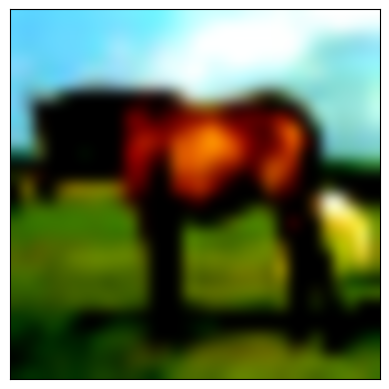

(3072,) 7


ValueError: not enough values to unpack (expected 2, got 1)

In [79]:
"""
Q4: Fooling Images
"""
# Initialize your own model
model = SoftmaxClassifier()
config = {}
target_class = None
correct_image = None
###########################################################################
# TODO: load your trained model, correctly classified image and set your  #
# hyperparameters, choose a different label as your target class          #
###########################################################################    
# load best model
model.load("./models/q3_3.pkl")

# load data
data = load_cifar10() 
X, y = data['X_test'], data['y_test']

# select a correctly predicted image
y_preds = model_predict(model, X)
correct_image = X[y == y_preds][0]
display_img(img_reshape(correct_image))
correct_class = np.array(y)[y == y_preds][0]
print(correct_image.shape, correct_class)

# select target class
target_class = 3

# run gradient ascent
fooling_image = gradient_ascent(
    model,
    target_class,
    init=correct_image
)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################



###########################################################################
# TODO: compute the (magnified) difference of your original image and the #
# fooling image, save all three images for your report                    #
###########################################################################


###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

### model: q3_1
(Iteration 1 / 6240) loss: 2.302478
(Epoch 0 / 20) train acc: 0.111000; val_acc: 0.101500
(Epoch 1 / 20) train acc: 0.391000; val_acc: 0.392400
(Epoch 2 / 20) train acc: 0.474000; val_acc: 0.428800
(Epoch 3 / 20) train acc: 0.513000; val_acc: 0.462000
(Iteration 1001 / 6240) loss: 1.474019
(Epoch 4 / 20) train acc: 0.543000; val_acc: 0.482600
(Epoch 5 / 20) train acc: 0.532000; val_acc: 0.469900
(Epoch 6 / 20) train acc: 0.577000; val_acc: 0.495900
(Iteration 2001 / 6240) loss: 1.086687
(Epoch 7 / 20) train acc: 0.558000; val_acc: 0.502300
(Epoch 8 / 20) train acc: 0.590000; val_acc: 0.506900
(Epoch 9 / 20) train acc: 0.600000; val_acc: 0.507300
(Iteration 3001 / 6240) loss: 0.957818
(Epoch 10 / 20) train acc: 0.656000; val_acc: 0.519700
(Epoch 11 / 20) train acc: 0.595000; val_acc: 0.518200
(Epoch 12 / 20) train acc: 0.668000; val_acc: 0.524000
(Iteration 4001 / 6240) loss: 0.866195
(Epoch 13 / 20) train acc: 0.662000; val_acc: 0.518800
(Epoch 14 / 20) train acc: 0.658

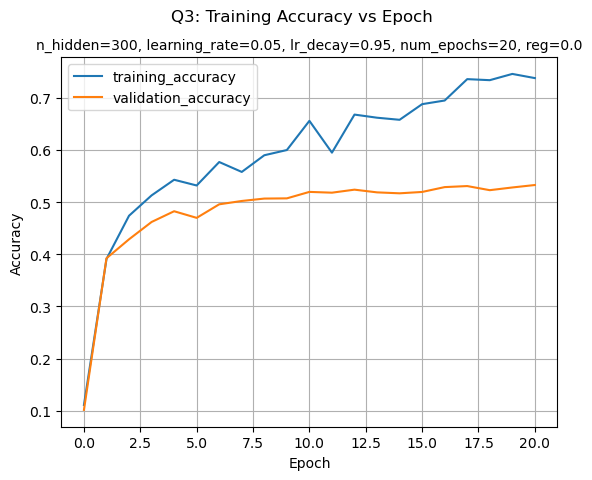

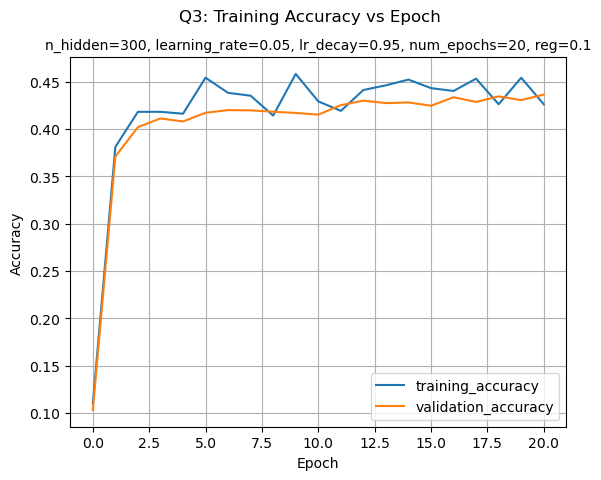

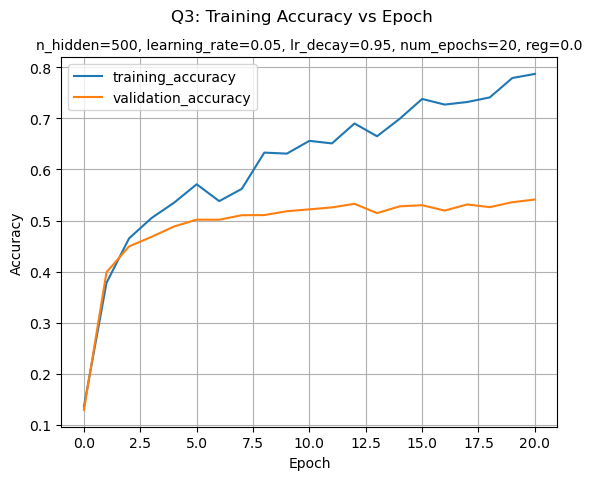

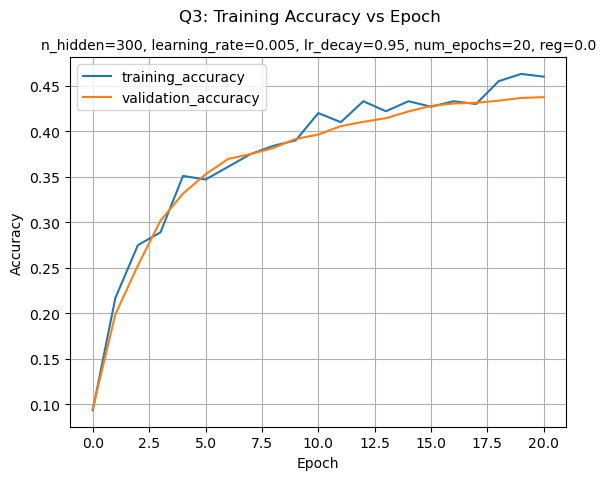

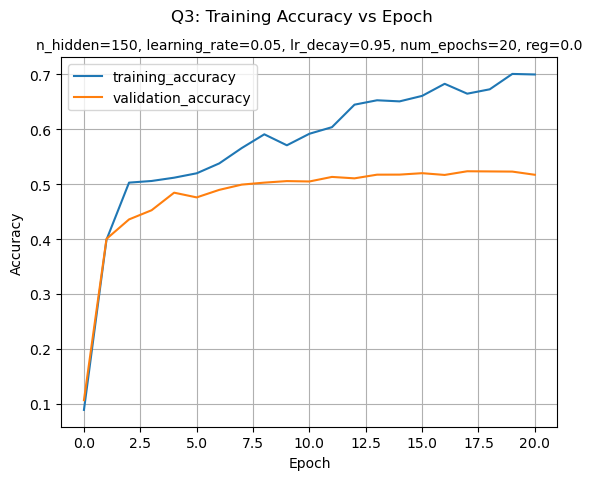

In [61]:
"""
Q3: Softmax Classifier with Hidden Layers

https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
"""
# cross-validation parameters
cv_params = [
    {
        'n_hidden': 300,
        'learning_rate': 5e-2,
        'lr_decay': 0.95,
        'num_epochs': 20,
        'reg': 0.0,
    },
    {
        'n_hidden': 300,
        'learning_rate': 5e-2,
        'lr_decay': 0.95,
        'num_epochs': 20,
        'reg': 0.1,
    },
    {
        'n_hidden': 500,
        'learning_rate': 5e-2,
        'lr_decay': 0.95,
        'num_epochs': 20,
        'reg': 0.0,
    },
    {
        'n_hidden': 300,
        'learning_rate': 5e-3,
        'lr_decay': 0.95,
        'num_epochs': 20,
        'reg': 0.0,
    },
    {
        'n_hidden': 150,
        'learning_rate': 5e-2,
        'lr_decay': 0.95,
        'num_epochs': 20,
        'reg': 0.0,
    },
]

# run cross-validation
for i, train_params in enumerate(cv_params):
    model_name = f"q3_{i + 1}"
    print(f"### model: {model_name}")
    # train model and report results
    train_acc_history, val_acc_history, test_acc = train(
        model_name,
        **train_params,
    )
    plot_training_history(
        model_name,
        "Q3: Training Accuracy vs Epoch",
        train_acc_history,
        val_acc_history,
        train_params
    )
    print("\n")

(Iteration 1 / 6240) loss: 2.299059
(Epoch 0 / 20) train acc: 0.184000; val_acc: 0.189700
(Epoch 1 / 20) train acc: 0.382000; val_acc: 0.377600
(Epoch 2 / 20) train acc: 0.403000; val_acc: 0.389500
(Epoch 3 / 20) train acc: 0.411000; val_acc: 0.395700
(Iteration 1001 / 6240) loss: 1.637105
(Epoch 4 / 20) train acc: 0.436000; val_acc: 0.396400
(Epoch 5 / 20) train acc: 0.463000; val_acc: 0.400300
(Epoch 6 / 20) train acc: 0.439000; val_acc: 0.398300
(Iteration 2001 / 6240) loss: 1.592326
(Epoch 7 / 20) train acc: 0.432000; val_acc: 0.398100
(Epoch 8 / 20) train acc: 0.435000; val_acc: 0.403700
(Epoch 9 / 20) train acc: 0.442000; val_acc: 0.397700
(Iteration 3001 / 6240) loss: 1.642001
(Epoch 10 / 20) train acc: 0.457000; val_acc: 0.404800
(Epoch 11 / 20) train acc: 0.434000; val_acc: 0.407100
(Epoch 12 / 20) train acc: 0.416000; val_acc: 0.405200
(Iteration 4001 / 6240) loss: 1.626946
(Epoch 13 / 20) train acc: 0.447000; val_acc: 0.401700
(Epoch 14 / 20) train acc: 0.432000; val_acc: 0.

(Epoch 78 / 100) train acc: 0.440000; val_acc: 0.407700
(Epoch 79 / 100) train acc: 0.417000; val_acc: 0.407200
(Epoch 80 / 100) train acc: 0.416000; val_acc: 0.406400
(Iteration 25001 / 31200) loss: 1.636304
(Epoch 81 / 100) train acc: 0.432000; val_acc: 0.405700
(Epoch 82 / 100) train acc: 0.450000; val_acc: 0.408400
(Epoch 83 / 100) train acc: 0.430000; val_acc: 0.407500
(Iteration 26001 / 31200) loss: 1.712793
(Epoch 84 / 100) train acc: 0.465000; val_acc: 0.408000
(Epoch 85 / 100) train acc: 0.432000; val_acc: 0.406600
(Epoch 86 / 100) train acc: 0.422000; val_acc: 0.409000
(Iteration 27001 / 31200) loss: 1.635690
(Epoch 87 / 100) train acc: 0.418000; val_acc: 0.407600
(Epoch 88 / 100) train acc: 0.444000; val_acc: 0.408400
(Epoch 89 / 100) train acc: 0.457000; val_acc: 0.408200
(Iteration 28001 / 31200) loss: 1.781891
(Epoch 90 / 100) train acc: 0.448000; val_acc: 0.408700
(Epoch 91 / 100) train acc: 0.433000; val_acc: 0.410500
(Epoch 92 / 100) train acc: 0.427000; val_acc: 0.407

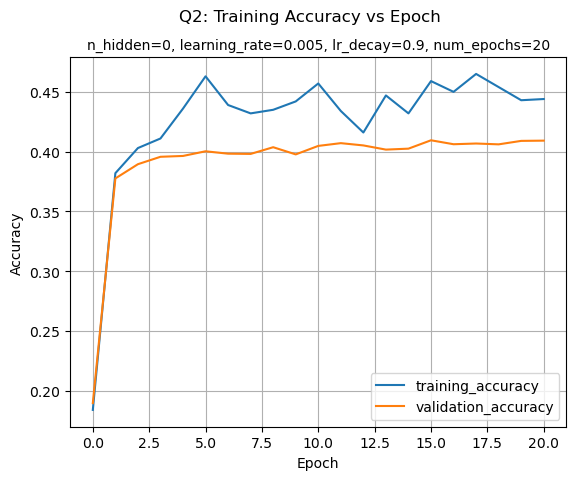

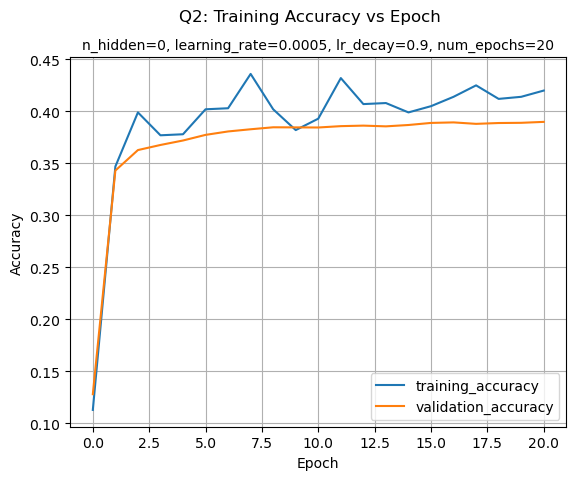

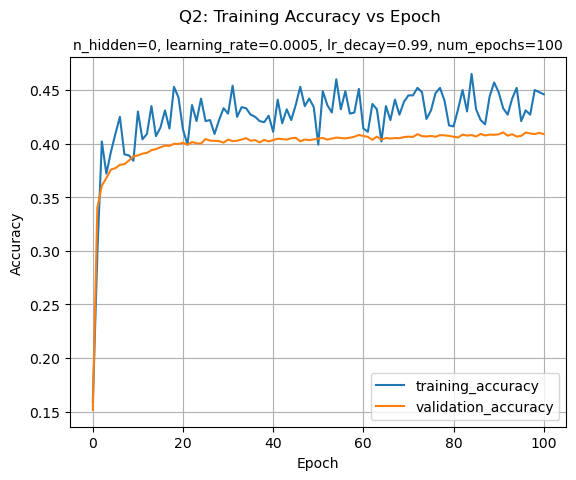

In [42]:
"""
Q2: Softmax Classifier with One Layer Neural Network

https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
"""
# cross-validation parameters
cv_params = [
    {
        'n_hidden': 0,
        'learning_rate': 5e-3,
        'lr_decay': 0.9,
        'num_epochs': 20,
    },
    {
        'n_hidden': 0,
        'learning_rate': 5e-4,
        'lr_decay': 0.9,
        'num_epochs': 20,
    },
    {
        'n_hidden': 0,
        'learning_rate': 5e-4,
        'lr_decay': 0.99,
        'num_epochs': 100,
    },
]

# run cross-validation
for i, train_params in enumerate(cv_params):
    model_name = f"q2_{i + 1}"
    # train model and report results
    train_acc_history, val_acc_history, test_acc = train(
        model_name,
        **train_params,
    )
    plot_training_history(
        model_name,
        "Q2: Training Accuracy vs Epoch",
        train_acc_history,
        val_acc_history,
        train_params
    )

S=[[ 1.00008565e+00 -5.38571036e-03]
 [ 6.62493948e-05  6.14124829e-01]]
t=[-0.00800811 -0.02994507]


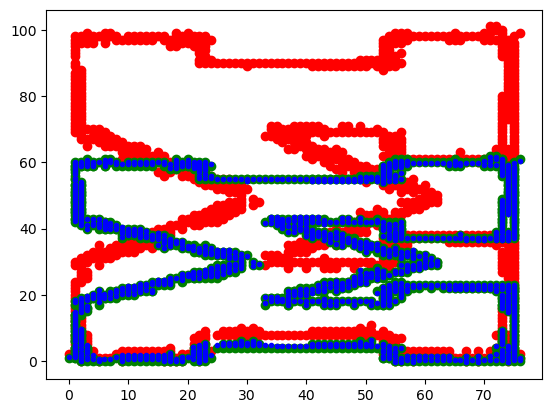

In [62]:
"""
Q1: Optimization and Fitting
"""
# load data
XY = np.load("./starter_code/points_case.npy")
x, y = XY[:,:2], XY[:,2:]

# tune your learning rate here.
S, t = lsq(x, y, learning_rate=0.00001)
print(f"S={S}\nt={t}")
y_hat = x.dot(S) + t

# plot results
plt.scatter(x[:,0],x[:,1],c="red")
plt.scatter(y[:,0],y[:,1],c="green")
plt.scatter(y_hat[:,0],y_hat[:,1],c="blue",marker='.')
plt.savefig("./figures/q1_case.jpg")

In [35]:
"""
test.py
"""
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def compare(output, r, name):
    wrong = False
    for k, v in output.items():
        if rel_error(v, r[k]) > 1e-5:
            print(name + ' fail! ' + k + ' is wrong.')
            wrong = True
            break
    if not wrong:
        print(name + ' pass!')

def test_fc():
    np.random.seed(442)
    x = np.random.randn(10,5)
    w = np.random.randn(5,3)
    b = np.random.randn(3)
    output = {}
    output['y'], cache = fc_forward(x, w, b)

    dout = np.random.randn(*output['y'].shape)
    output['dx'], output['dw'], output['db'] = fc_backward(dout, cache)
    
    r = np.load('starter_code/fc.npz')
    compare(output, r, 'fc')

def test_relu():
    np.random.seed(442)
    x = np.random.randn(10)
    output = {}
    output['y'], cache = relu_forward(x)

    dout = np.random.randn(*output['y'].shape)
    output['dx'] = relu_backward(dout, cache)

    r = np.load('starter_code/relu.npz')
    compare(output, r, 'relu')

def test_l2_loss():
    np.random.seed(442)
    x = np.random.randn(10, 9)
    y = np.random.randn(10, 9)
    output = {}
    output['loss'], output['dx'] = l2_loss(x,y)

    r = np.load('starter_code/l2_loss.npz')
    compare(output, r, 'l2_loss')

def test_softmax_loss():
    np.random.seed(442)
    x = np.random.randn(10, 9)
    y = np.random.randint(0, 9, size = 10)
    output = {}
    output['loss'], output['dx'] = softmax_loss(x,y)

    r = np.load('starter_code/softmax_loss.npz')
    compare(output, r, 'softmax_loss')

# run tests
test_fc()
test_relu()
test_l2_loss()
test_softmax_loss()

fc pass!
relu pass!
l2_loss pass!
softmax_loss pass!
